In [43]:
import numpy as np
from numpy.fft import fft
from scipy.signal.windows import hamming

def eeg_rpsd(EEG, nfreqs=None, pct_data=100):
    # clean input cutoff freq
    nyquist = EEG['srate'] // 2
    if nfreqs is None or nfreqs > nyquist:
        nfreqs = nyquist
    
    # setup constants
    ncomp = EEG['icaweights'].shape[0]
    
    # Hamming window
    n_points = min(EEG['pnts'], EEG['srate'])
    m = n_points
    isOddLength = m % 2
    if isOddLength:
        x = np.arange(0, (m - 1) / 2 + 1) / (m - 1)
    else:
        x = np.arange(0, m / 2) / (m - 1)
    
    a = 0.54
    window = a - (1 - a) * np.cos(2 * np.pi * x)
    if isOddLength:
        window = np.concatenate([window, window[-2::-1]])
    else:
        window = np.concatenate([window, window[::-1]])
    
    cutoff = (EEG['pnts'] // n_points) * n_points
    index = np.add.outer(np.arange(0, cutoff - n_points//2, n_points // 2), np.arange(0, n_points)).astype(int).transpose()
    
    np.random.seed(0)  # rng('default') in MATLAB
    n_seg = index.shape[1] * EEG['trials']
    subset = np.random.permutation(n_seg)[:int(n_seg * pct_data / 100)]
    
    # calculate windowed spectrums
    psdmed = np.zeros((ncomp, nfreqs))
    for it in range(ncomp):
        temp = np.reshape(EEG['icaact'][it, index, :], (1, index.shape[0], index.shape[1] * EEG['trials']))
        temp = temp[:, :, subset] * window[:, np.newaxis]
        temp = fft(temp, n_points, axis=1)
        temp = np.abs(temp) ** 2
        temp = temp[:, 1:nfreqs + 1, :] * 2 / (EEG['srate'] * np.sum(window ** 2))
        if nfreqs == nyquist:
            temp[:, -1, :] /= 2
        psdmed[it, :] = 20 * np.log10(np.median(temp, axis=2))
    
    return psdmed

def test_eeg_rpsd():
    EEG = {
        'srate': 256,
        'icaweights': np.random.randn(10, 256),
        'pnts': 1000,
        'trials': 5,
        'icaact': np.random.randn(10, 1000, 5)
    }
    
    psdmed = eeg_rpsd(EEG, 100)
    assert psdmed.shape == (10, 100)
    assert np.all(np.isfinite(psdmed))

# test_eeg_rpsd()
eeg_rpsd(EEG, 100)

Creating RawArray with float64 data, n_channels=32, n_times=30720
    Range : 0 ... 30719 =      0.000 ...   239.992 secs
Ready.


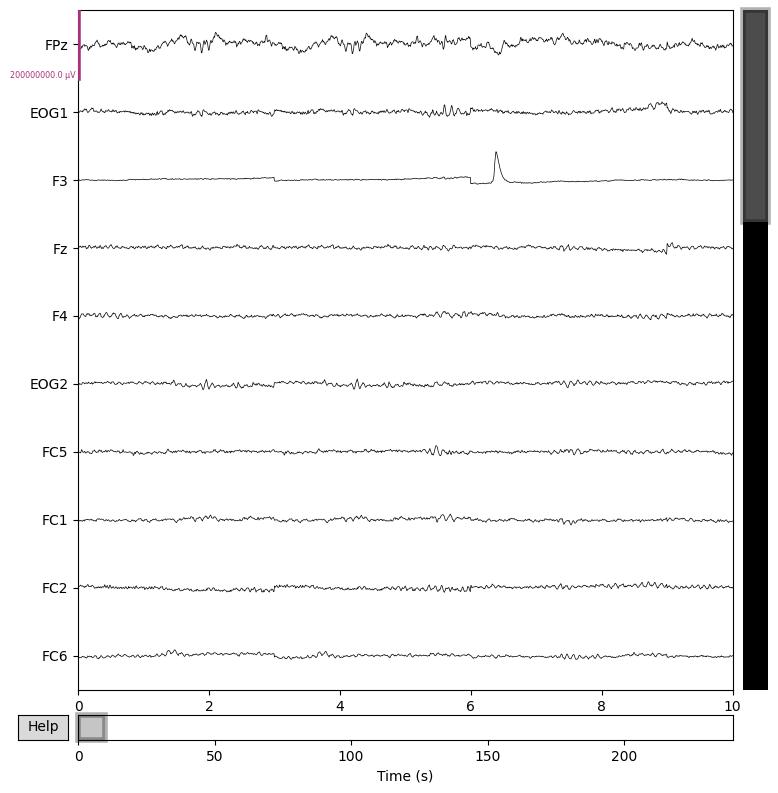

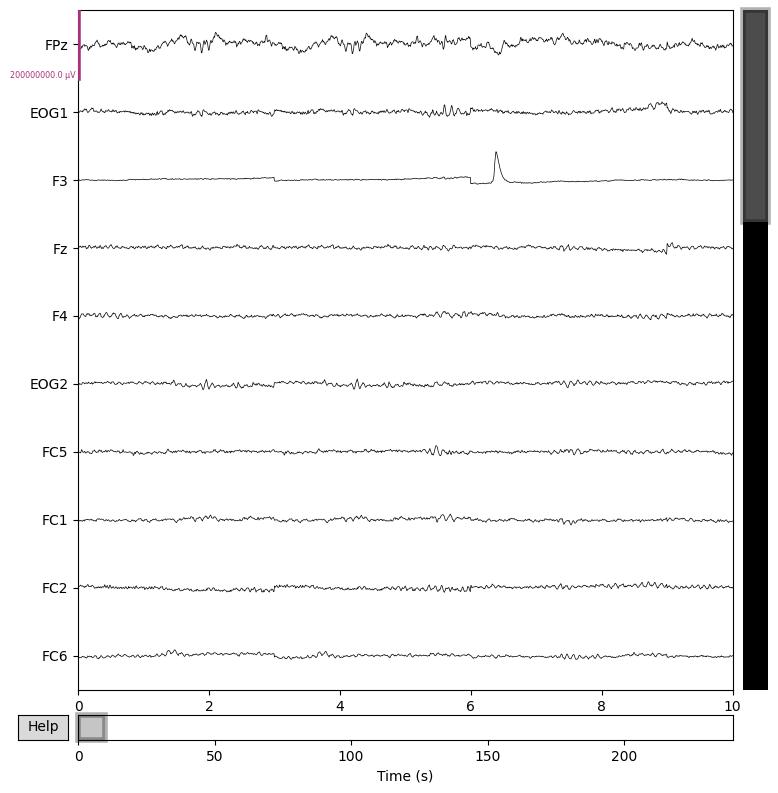

In [80]:
from topoplot import topoplot
from pop_loadset import pop_loadset
import os

eeglab_file_path = '/System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.set'
EEG = pop_loadset(eeglab_file_path)

# plot data using MNE

import mne
import matplotlib.pyplot as plt

# create MNE info structure
info = mne.create_info(ch_names=[ x['labels'] for x in EEG['chanlocs']], sfreq=EEG['srate'], ch_types='eeg')

# create MNE Raw object
raw = mne.io.RawArray(EEG['icaact'].reshape(EEG['nbchan'], -1), info)

# plot data
raw.plot(n_channels=10, scalings=100, title='Data from arrays', show=True, block=True, duration=10.0)    

# plot topoplot
# topoplot(EEG['icawinv'][:, 0], EEG['chanlocs'], show=True)

In [79]:
import pop_loadset
import importlib
importlib.reload(pop_loadset)  # Step 3: Reload the library to reflect the changes
from pop_loadset import pop_loadset

EEG = pop_loadset(eeglab_file_path)
EEG['data']

array([[[  0.29972056,  14.770853  ,   9.815416  , ..., -20.407536  ,
         -14.395958  , -19.216618  ],
        [-13.956852  , -19.480728  ,  -6.4039726 , ...,   0.51544553,
          -1.7732241 ,  12.674225  ],
        [ 12.637054  ,  22.995209  ,  15.691086  , ...,  28.321348  ,
          26.559828  ,  19.417301  ],
        ...,
        [ -8.863834  , -10.876614  ,   5.925953  , ..., -28.239748  ,
         -27.819056  , -27.01903   ],
        [-25.721594  , -14.317928  , -12.97101   , ...,   9.363076  ,
          -3.6610925 ,  -7.485513  ],
        [ -2.5577486 , -11.601339  ,  -9.666773  , ...,   3.2351382 ,
          13.994954  ,  16.028934  ]],

       [[  8.974581  ,  24.900438  ,   5.119145  , ...,  -9.236571  ,
          -0.2412441 , -14.362872  ],
        [ -1.8190157 , -12.254649  ,   2.770159  , ..., -15.726609  ,
         -24.388391  ,  -7.236197  ],
        [ -8.306385  ,   3.7299058 ,  -9.855094  , ...,   9.551514  ,
           9.539445  ,   4.996356  ],
        ...,
